In [3]:
from pHcalc import Acid, Inert, System
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_context('talk')

a = b = c = d = e = f = np.linspace(0,1,12) # 12
A, B, C, D, E, F = np.meshgrid(a,b,c,d,e,f)
g1 = np.vstack([I.ravel() for I in (A,B,C,D,E,F)]).T
G = np.array([1-np.sum(gi) for gi in g1]).reshape(-1,1)
grid = np.hstack([g1,G])
grid = grid[np.where(G>=0)[0],:]
grid.shape

def get_pH(x, base_conc, vtot = 1): 
    v1 = x[0]*vtot
    c1 = v1*base_conc[0]/vtot
    
    v2 = x[1]*vtot
    c2 = v2*base_conc[1]/vtot

    v3 = x[2]*vtot
    c3 = v3*base_conc[2]/vtot

    vs = []
    cs = []
    for ii,xi in enumerate(x):
        vs.append(xi*vtot)
        cs.append(vs[-1]*base_conc[ii]/vtot)
    
    components = [Acid(pKa=[2,16, 7.21, 12.32], charge=0, conc=cs[0]), # H3PO4
              Inert(charge=1, conc=cs[1]), # NaOH
              Acid(pKa=[2,16, 7.21, 12.32], charge=0, conc=cs[0]), # H3PO4
              Inert(charge=1, conc=cs[1]), # KOH
              Inert(charge=1, conc=cs[1]), # KOH
              Acid(pKa=[-3, 1.92], charge=1, conc=cs[5]), # H2SO4
              Inert(charge=-1, conc=cs[6])] # HCl
    #components = [Acid(pKa=[2,16, 7.21, 12.32], charge=0, conc=cs[0]), # H3PO4
    #          Inert(charge=1, conc=cs[1]), # NaOH
    #          Acid(pKa=3.14, charge=0, conc=cs[2]), # HF
    #          Acid(pKa=[6.46, 10.4], charge=0, conc=cs[3]), # H2CO3
    #          Acid(pKa=[35], charge=1, conc=cs[4]), # HBrO2
    #          Acid(pKa=[-3, 1.92], charge=1, conc=cs[5]), # H2SO4
    #          Inert(charge=-1, conc=cs[6])] # HCl
              
    system = System(*components)
    system.pHsolve()
    return(system.pH) # Should print

[0.37 0.95 0.73 0.6  0.16 0.16 0.06]


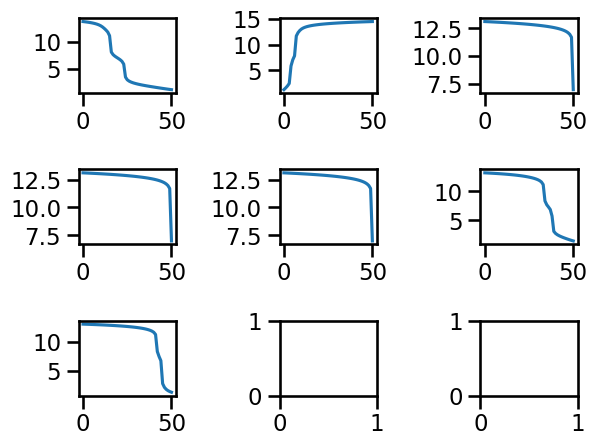

In [48]:
from dexpy.cox_effects import generate_cox_points
np.random.seed(42)
base_conc = np.round(np.random.rand(7),2)
#base_conc = np.array([1, 1, 2, 0.1, 3, 0.1,0.7])*10 #np.array([0.5, 0.5, 0.1, 0.1, 0.1, 0.1,0.1])
print(base_conc)
f = lambda x: get_pH(x, base_conc = base_conc)

fig,axes = plt.subplots(nrows=3,ncols=3)
for ii,ax in enumerate(axes.ravel()):
    i = ii
    
    refp = np.ones(7)*0.25
    try:
        refp[i] = 0
    except:
         break
    vec = generate_cox_points(refp, i, 50)
    
    
    ax.plot([f(vi) for vi in vec])
plt.tight_layout()

[0.37 0.95 0.73 0.6  0.16 0.16 0.06]


100%|████████████████████████████████████| 12275/12275 [00:14<00:00, 859.93it/s]


(array([4442.,  310.,   14.,  126.,  700.,  289.,    0.,   25., 1318.,
        5051.]),
 array([ 1.09061508,  2.42703819,  3.7634613 ,  5.09988441,  6.43630753,
         7.77273064,  9.10915375, 10.44557686, 11.78199997, 13.11842308,
        14.45484619]),
 <BarContainer object of 10 artists>)

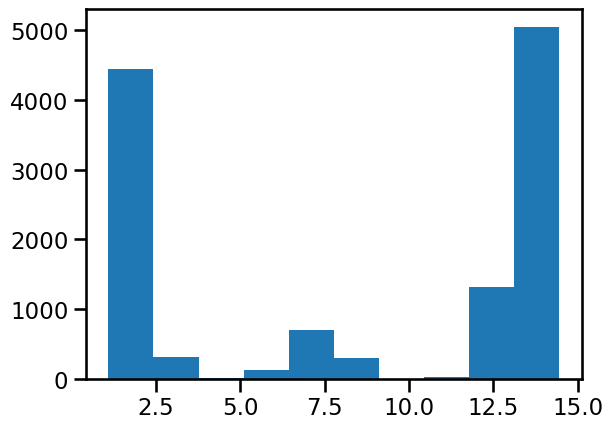

In [5]:
from tqdm import tqdm
from joblib import Parallel, delayed  


print(base_conc)
f = lambda x: get_pH(x, base_conc = base_conc)

pHs = Parallel(n_jobs=-1)(delayed(f)(xi) for xi in tqdm(grid)) 
fig,ax = plt.subplots()
ax.hist(pHs)

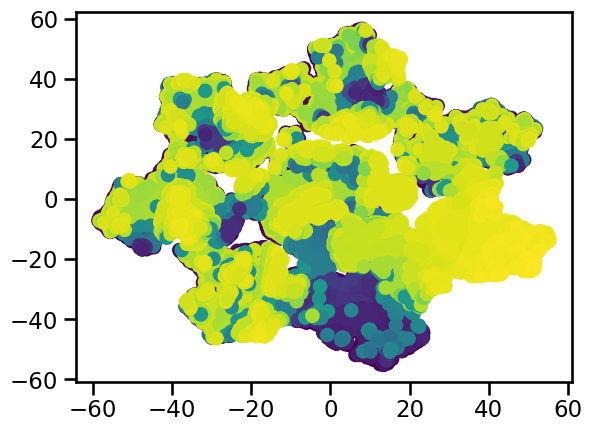

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_jobs=-1).fit_transform(grid)
fig,ax = plt.subplots()
ax.scatter(*tsne.T, c=pHs)

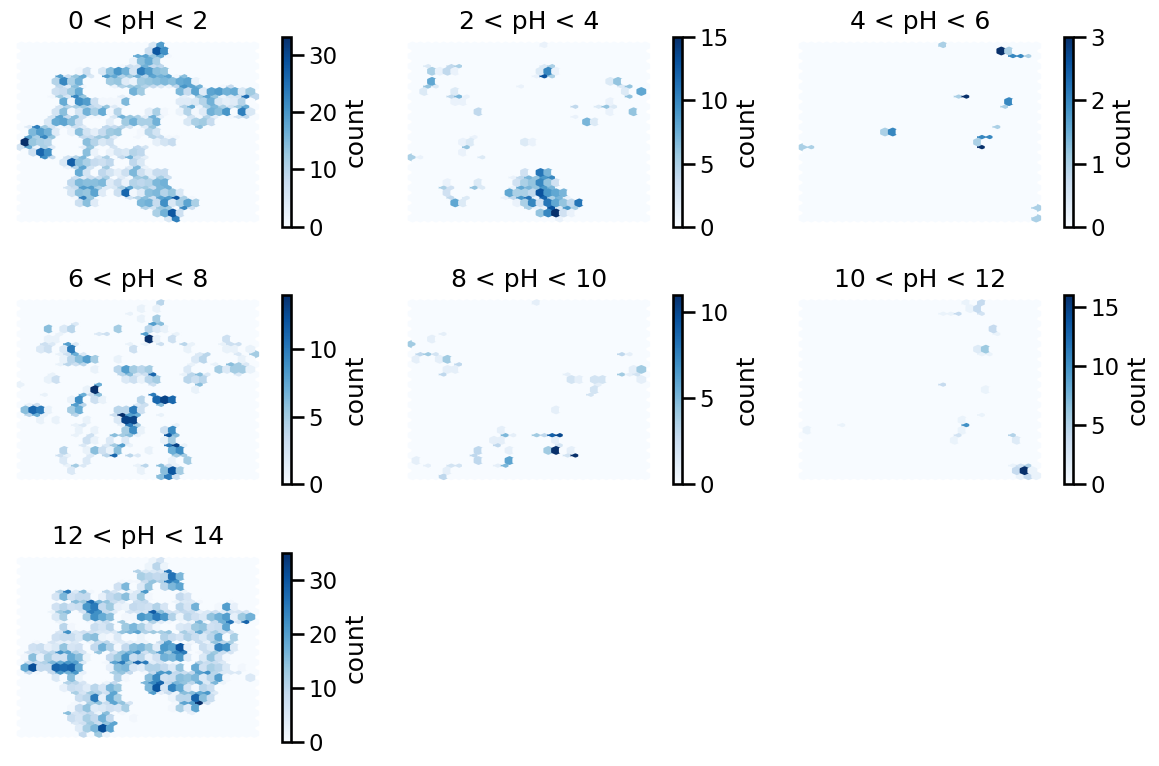

In [49]:
phcrits = np.arange(0,16,2)

fig,axes = plt.subplots(ncols=3,nrows=3, figsize=(12,8))
for pi,phcrit in enumerate(phcrits[:-1]):
    mi = phcrit
    ma = phcrits[pi+1]
    ax = axes.ravel()[pi]
    vals = tsne[(pHs>mi)&(pHs<ma)]
    a = ax.hexbin(*vals.T, cmap = 'Blues', gridsize = 30)
    plt.colorbar(a, label='count')
    ax.set_title('%i < pH < %i'%(mi,ma))
for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

plt.savefig('../../figures/SI_pH_titration1.png', dpi=300)

array([ 0,  2,  4,  6,  8, 10, 12, 14])

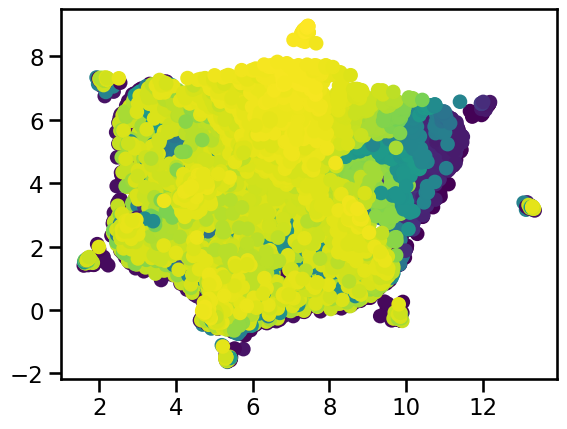

In [89]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(grid)
fig,ax = plt.subplots()
ax.scatter(*embedding[:,:2].T, c=pHs)

In [6]:
f = lambda x: get_pH(x.ravel(), base_conc = base_conc)

def get_label(x):
    pH = f(x)
    if pH <= 4:
        return 0
    elif pH > 4 and pH < 10:
        return 1
    else:
        return 2

In [5]:
from borfr import BO_RFR, fps
import warnings
warnings.filterwarnings("ignore")

np.random.seed(5)

X_init = fps(grid,50)

y_init = np.array([f(xi) for xi in X_init])

x_test = fps(grid, 4000)

regm = 'ORFC'
clm = 'ORFC'

esl = 'AC'

n_iter = 200
nb = 1
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=1.5, 
             est_labels=esl, N_batch=nb, 
             class_method = clm, reg_method = regm, k_adaptive=True)

bor.run(n_iter_b)

rand_scores = []
rand_all_scores = []
for i in range(2):
    rand = BO_RFR(X_init, y_init, grid, f, x_test, 
                  acq='random',gl = get_label,  
                  est_labels=esl, N_batch=1,
                  class_method = clm, reg_method = regm)
    
    rand.run(n_iter)
    rand_scores.append(rand.scores)
    rand_all_scores.append(rand.all_scores)


sf = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm)

sf.run(n_iter)

gp = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm, gpr=True)

gp.run(n_iter)

bor2 = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=.3, 
             est_labels=esl, N_batch=nb, 
             class_method = 'RFC', reg_method = 'RFC', k_adaptive=True)

bor2.run(n_iter_b)


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 216.09it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:20<00:00, 198.82it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:22<00:00,  2.42it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:20<00:00, 196.60it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:22<00:00,  2.43it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:20<00:00, 195.99it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:24<00:00,  2.37it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:20<00:00, 195.21it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:47<00:00,  4.17it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:20<00:00, 195.86it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


In [8]:

bor3 = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=1.5, 
             est_labels=esl, N_batch=nb, 
             class_method = 'RFC', reg_method = 'RFC', k_adaptive=True)

bor3.run(n_iter_b)

generating test data


100%|██████████████████████████████████████| 4000/4000 [00:18<00:00, 221.89it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 200/200 [01:46<00:00,  1.87it/s]


Text(0, 0.5, 'reference pH')

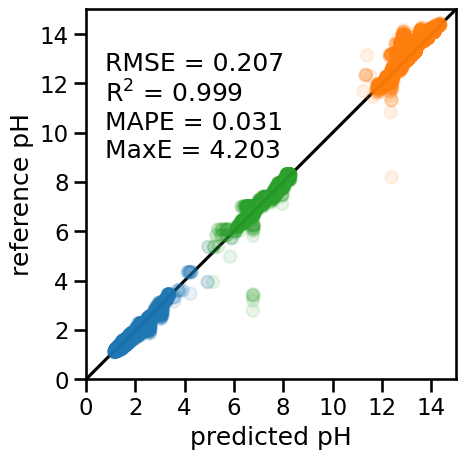

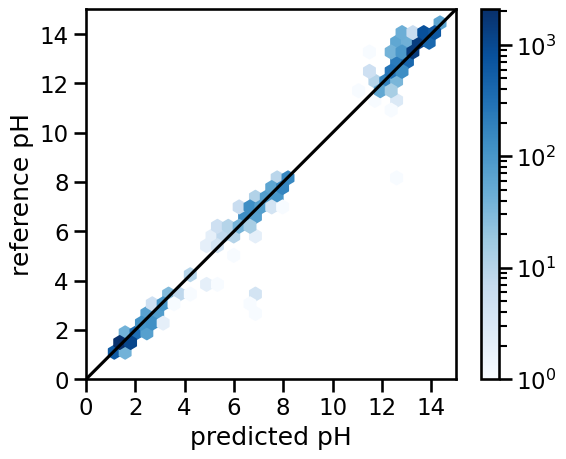

In [23]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, max_error

fig,ax = plt.subplots()
pred = bor3.reg_models[180].predict(grid)
E = pred-pHs
RMSE = np.sqrt(np.mean(E**2))
r2 = r2_score(pred, pHs)
mape = mean_absolute_percentage_error(pred, pHs)
maxe = max_error(pred,pHs)
ax.scatter(pred,pHs, alpha=0.1, c=bor3.classifier.predict(grid), cmap='tab10',vmin=0,vmax=10)
ax.text(0.05,0.6,'RMSE = %.3f\nR$^2$ = %.3f\nMAPE = %.3f\nMaxE = %.3f'%(RMSE, r2, mape,maxe), transform = ax.transAxes)

ax.plot((0,1),(0,1),c='k',zorder=-1, transform=ax.transAxes)
ax.set_xticks(np.arange(0,16,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xlim(0,15)
ax.set_ylim(0,15)
ax.set_aspect('equal')
ax.set_xlabel('predicted pH')
ax.set_ylabel('reference pH')


fig,ax = plt.subplots()

a = ax.hexbin(pred,pHs, cmap = 'Blues', gridsize=30, bins='log', zorder=-1)
plt.colorbar(a)
ax.plot((0,1),(0,1),c='k',zorder=-1, transform=ax.transAxes)
ax.set_xticks(np.arange(0,16,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xlim(0,15)
ax.set_ylim(0,15)
ax.set_aspect('equal')
ax.set_xlabel('predicted pH')
ax.set_ylabel('reference pH')

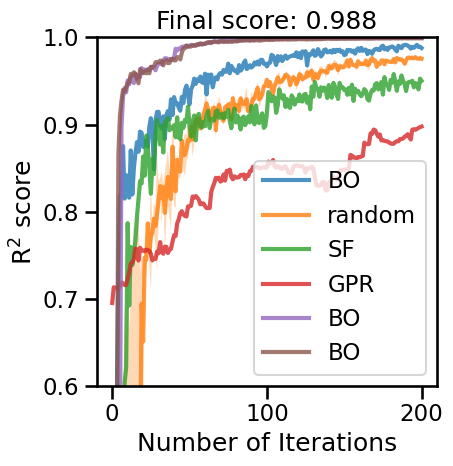

In [9]:
fig, ax2 = plt.subplots(ncols=1, figsize=(5,5))

ax2.plot(np.arange(bor.n_iters+1)*nb,bor.scores,lw=3,alpha=0.8, label='BO')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0),lw=3,alpha=0.8, label='random')
    ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
                     np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),sf.scores,lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),gp.scores,lw=3,alpha=0.8, label='GPR')
except:
    pass
ax2.plot(np.arange(bor2.n_iters+1)*nb,bor2.scores,lw=3,alpha=0.8, label='BO')
ax2.plot(np.arange(bor3.n_iters+1)*nb,bor3.scores,lw=3,alpha=0.8, label='BO')
ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$^2$ score')
ax2.set_ylim(0.6,1)
ax2.legend()
plt.tight_layout()

BO 0.545
rand 0.54
SF 0.575
GPR 0.595


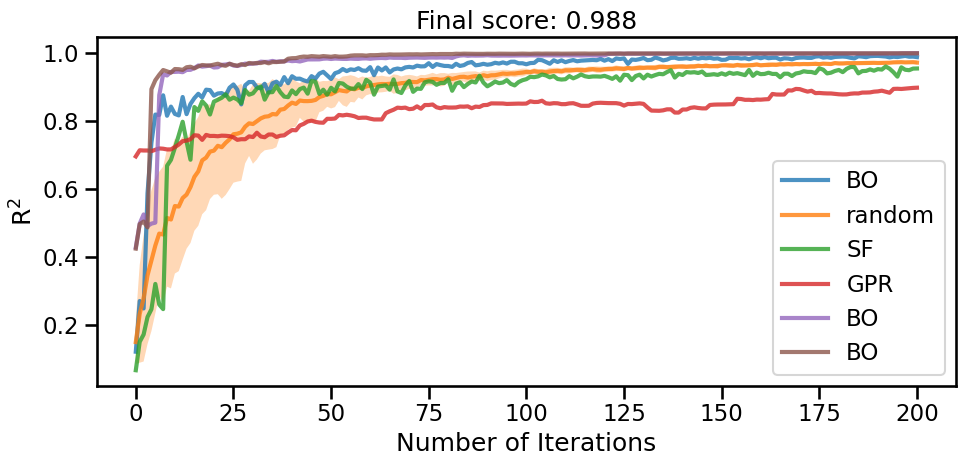

In [111]:
fig, ax2 = plt.subplots(ncols=1, figsize=(10,5))

def get_dec_eff(scores, type):
    if type in ['R$^2$']:
        max = True
    else:
        max = False
    n_sc = len(scores)-1
    n_pos = 0
    for ii,sc in enumerate(scores[1:]):
        if max:
            if sc > scores[ii-1]:
                n_pos += 1
        else:
            if sc < scores[ii-1]:
                n_pos += 1
    return n_pos / n_sc

score_labels = ['R$^2$','RMSE','MAPE','MaxE']
si = 0

ax2.plot(np.arange(bor.n_iters+1)*nb,np.array(bor.all_scores)[:,si],lw=3,alpha=0.8, label='BO')
print('BO',get_dec_eff(np.array(bor.all_scores)[:,si], score_labels[si]))
try:
    ax2.plot(np.arange(rand.n_iters+1),np.mean(np.array(rand_all_scores),axis=0)[:,si],lw=3,alpha=0.8, label='random')
    ax2.fill_between(np.arange(rand.n_iters+1),np.mean(np.array(rand_all_scores),axis=0)[:,si]-np.std(np.array(rand_all_scores),axis=0)[:,si],
                     np.mean(np.array(rand_all_scores),axis=0)[:,si]+np.std(np.array(rand_all_scores),axis=0)[:,si], alpha=0.3, fc='C1')
    print('rand',get_dec_eff(np.array(rand.all_scores)[:,si], score_labels[si]))
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),np.array(sf.all_scores)[:,si],lw=3,alpha=0.8, label='SF')
    print('SF',get_dec_eff(np.array(sf.all_scores)[:,si], score_labels[si]))
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),np.array(gp.all_scores)[:,si],lw=3,alpha=0.8, label='GPR')
    print('GPR',get_dec_eff(np.array(gp.all_scores)[:,si], score_labels[si]))
except:
    pass
ax2.plot(np.arange(bor2.n_iters+1)*nb,np.array(bor2.all_scores)[:,si],lw=3,alpha=0.8, label='BO')
ax2.plot(np.arange(bor3.n_iters+1)*nb,np.array(bor3.all_scores)[:,si],lw=3,alpha=0.8, label='BO')
ax2.set_title('Final score: %.3f'%bor.all_scores[-1][si])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel(score_labels[si])
#ax2.set_ylim(0,1)
ax2.legend()
plt.tight_layout()

array([3.65601998, 3.4807552 , 3.37409735, 3.23010073, 3.11696817,
       3.02062032, 2.9376287 , 2.93751018, 2.82371081, 2.82515163,
       2.74477263, 2.74145991, 2.68608407, 2.66218427, 2.60403519,
       2.51890705, 2.46007242, 2.35751351, 2.33108637, 2.26986046,
       2.27055625, 2.21837814, 2.23497164, 2.18672963, 2.14993396,
       2.09607958, 2.09237396, 2.08019686, 2.0259221 , 1.9945881 ,
       1.99318585, 1.96264244, 1.93338538, 1.91542063, 1.91271529,
       1.87251053, 1.88461171, 1.83072545, 1.82083268, 1.76708525,
       1.73270642, 1.75329926, 1.71084662, 1.71538343, 1.71471855,
       1.71149489, 1.69262093, 1.6596978 , 1.64145352, 1.61389274,
       1.61571353, 1.58561704, 1.55128249, 1.55621448, 1.56596222,
       1.52009794, 1.53379621, 1.51194643, 1.5094986 , 1.48779642,
       1.47517391, 1.46062042, 1.45035931, 1.44161045, 1.44659112,
       1.44021986, 1.43927553, 1.43925853, 1.42882287, 1.42242221,
       1.4007352 , 1.40578562, 1.41145748, 1.37086355, 1.37912

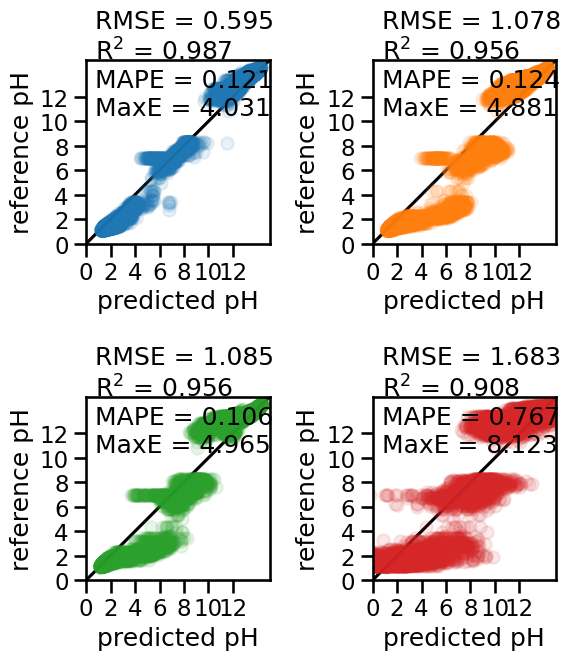

In [114]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, max_error
fig,axes = plt.subplots(ncols=2,nrows=2, figsize=(6,7))
mods = [bor, rand, sf, gp]
for ii,ax in enumerate(axes.ravel()):
    pred = mods[ii].model.predict(grid)
    #pred = mods[ii].reg_models[50].predict(grid)
    E = pred-pHs
    RMSE = np.sqrt(np.mean(E**2))
    r2 = r2_score(pred, pHs)
    mape = mean_absolute_percentage_error(pred, pHs)
    maxe = max_error(pred,pHs)
    ax.scatter(pred,pHs, alpha=0.1, c='C%i'%(ii))
    ax.text(0.05,0.7,'RMSE = %.3f\nR$^2$ = %.3f\nMAPE = %.3f\nMaxE = %.3f'%(RMSE, r2, mape,maxe), transform = ax.transAxes)
    
    ax.plot((0,1),(0,1),c='k',zorder=-1, transform=ax.transAxes)
    ax.set_xticks(np.arange(0,14,2))
    ax.set_yticks(np.arange(0,14,2))
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    ax.set_aspect('equal')
    ax.set_xlabel('predicted pH')
    ax.set_ylabel('reference pH')
plt.tight_layout()

In [212]:
for i in np.unique(bor.labels):
    print(np.mean(bor.y[bor.labels==i]),np.var(bor3.y[bor.labels==i]))

2.0220232124788193 19.44470898300844
12.947972795439929 21.13734175342393
7.251634063720704 12.0309947786781


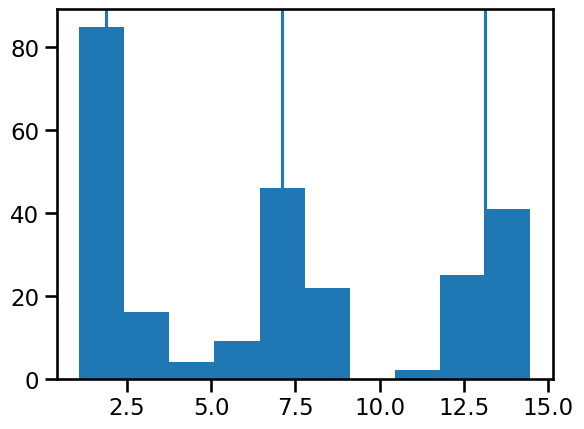

In [214]:
fig,ax = plt.subplots()
ax.hist(bor2.y)
for i in np.unique(bor2.labels):
    ax.axvline(np.mean(bor2.y[bor2.labels==i]))

[0.10898458 0.13503456 0.14141414 0.1323764  0.1903243  0.14619883
 0.1456672 ]
[0.02937063 0.24335664 0.12727273 0.07412587 0.26433566 0.13146853
 0.13006993]
[0.02597403 0.12987013 0.0974026  0.23376623 0.29220779 0.16883117
 0.05194805]


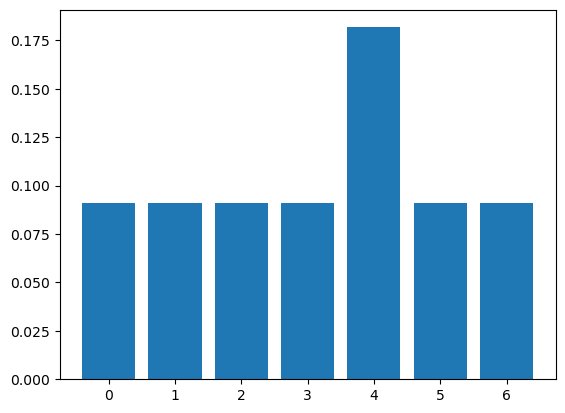

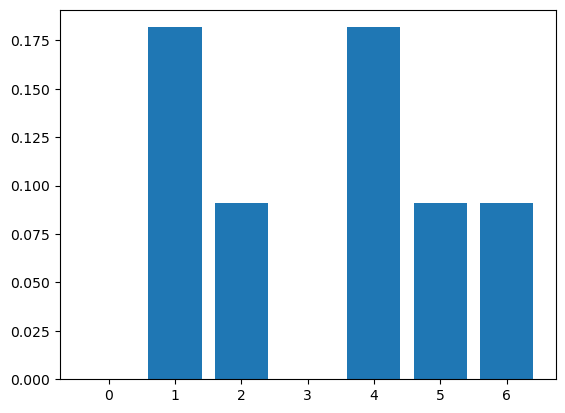

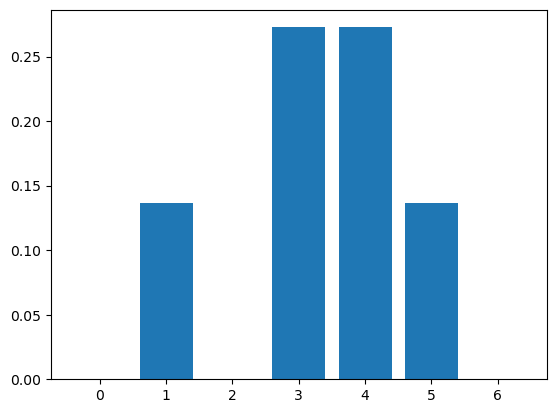

In [53]:
for i in np.unique(bor.labels):
    print(np.mean(bor.X[bor.labels==i],axis=0))
    fig,ax = plt.subplots()
    ax.bar(range(7),np.percentile(bor.X[bor.labels==i],50,axis=0))

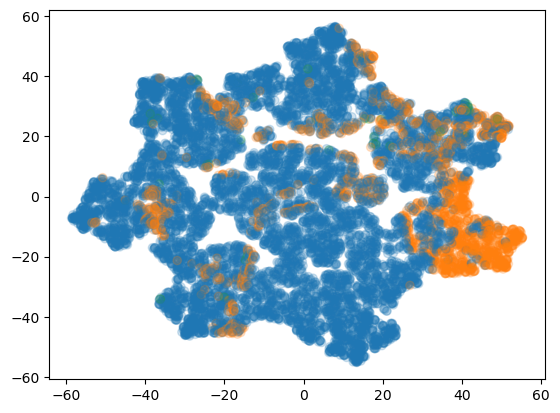

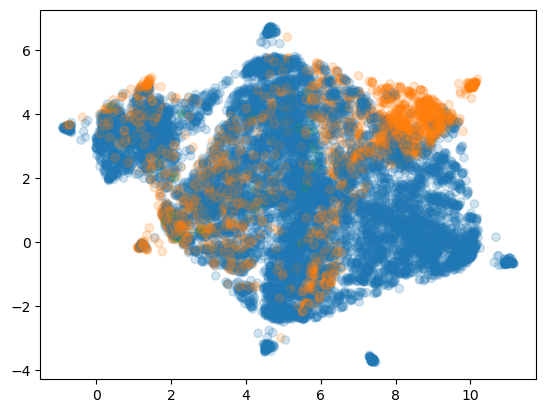

In [57]:
fig,ax = plt.subplots()
ax.scatter(*tsne.T, c=bor.classifier.predict(grid),cmap='tab10', vmin=0,vmax=10,alpha=0.2)
fig,ax = plt.subplots()
ax.scatter(*embedding[:,:2].T, c=bor.classifier.predict(grid),cmap='tab10', vmin=0,vmax=10,alpha=0.2)

[0.5 0.5 0.1 0.1 0.1 0.1 0.2]


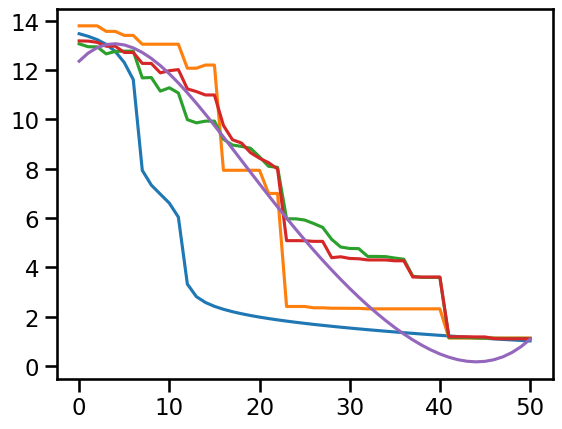

In [140]:
from dexpy.cox_effects import generate_cox_points
np.random.seed(42)
base_conc = np.round(np.random.rand(7),2)
base_conc = np.array([0.5, 0.5, 0.1, 0.1, 0.1, 0.1,0.2]) #np.array([0.5, 0.5, 0.1, 0.1, 0.1, 0.1,0.1])
print(base_conc)
f = lambda x: get_pH(x, base_conc = base_conc)


i = 0

refp = np.ones(7)*0.25
refp[i] = 0
vec = generate_cox_points(refp, i, 50)

fig,ax = plt.subplots()
ax.plot([f(vi) for vi in vec])
ax.plot(bor3.model.predict(vec))
ax.plot(rand.model.predict(vec))
ax.plot(sf.model.predict(vec))
ax.plot(gp.model.predict(vec))

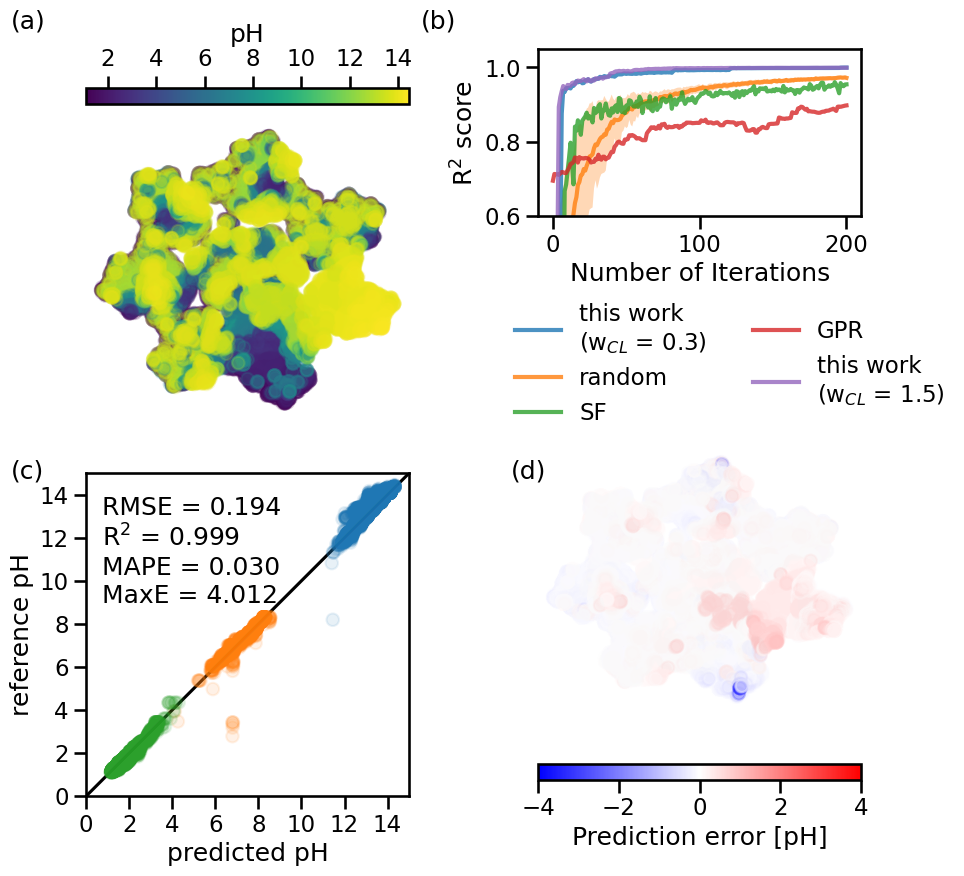

In [233]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(ncols=2,nrows=4)

ax2 = fig.add_subplot(gs[0,1])

#ax2.plot(np.arange(bor.n_iters+1)*nb,bor.scores,lw=3,alpha=0.8, label='BO')
ax2.plot(np.arange(bor2.n_iters+1)*nb,bor2.scores,lw=3,alpha=0.8, label='this work\n(w$_{CL}$ = 0.3)')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0),lw=3,alpha=0.8, label='random')
    ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
                     np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),sf.scores,lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),gp.scores,lw=3,alpha=0.8, label='GPR')
except:
    pass

ax2.plot(np.arange(bor3.n_iters+1)*nb,bor3.scores,lw=3,alpha=0.8, label='this work\n(w$_{CL}$ = 1.5)')
#ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$^2$ score')
ax2.set_ylim(0.6,1.05)
ax2.legend(frameon=False,loc=(-.1,-1.3),ncols=2)


ax = fig.add_subplot(gs[:2,0])
a = ax.scatter(*tsne.T, c=pHs,alpha=0.2)
cbar = plt.colorbar(a, label='pH',location='top', ticks=np.arange(0,15,2))
cbar.solids.set(alpha=1)
ax.set_axis_off()

ax = fig.add_subplot(gs[2:,0])
#ax.scatter(*tsne.T, c=bor3.classifier.predict(grid),cmap='tab10', vmin=0,vmax=10,alpha=.05)
#a = ax.scatter(*tsne.T, c=bor3.model.predict(grid),alpha=.2)
#plt.colorbar(a, label='Predicted pH',location='bottom', ticks=np.arange(0,15,2))
#ax.set_axis_off()

pred = bor3.model.predict(grid)
E = pred-pHs
RMSE = np.sqrt(np.mean(E**2))
r2 = r2_score(pred, pHs)
mape = mean_absolute_percentage_error(pred, pHs)
maxe = max_error(pred,pHs)
ax.scatter(pred,pHs, alpha=0.1, c=bor3.classifier.predict(grid), cmap='tab10',vmin=0,vmax=10)
ax.text(0.05,0.6,'RMSE = %.3f\nR$^2$ = %.3f\nMAPE = %.3f\nMaxE = %.3f'%(RMSE, r2, mape,maxe), transform = ax.transAxes)

ax.plot((0,1),(0,1),c='k',zorder=-1, transform=ax.transAxes)
ax.set_xticks(np.arange(0,16,2))
ax.set_yticks(np.arange(0,16,2))
ax.set_xlim(0,15)
ax.set_ylim(0,15)
ax.set_aspect('equal')
ax.set_xlabel('predicted pH')
ax.set_ylabel('reference pH')


ax = fig.add_subplot(gs[2:,1])
diff = pHs-bor3.model.predict(grid)
a = ax.scatter(*tsne.T, c=diff,cmap='bwr',alpha=.2,vmin=-4,vmax=4)
cbar = plt.colorbar(a, label='Prediction error [pH]',location='bottom')
cbar.solids.set(alpha=1)
ax.set_axis_off()


plt.subplots_adjust(wspace=.4)
fig.text(0.05,0.9,'(a)')#, fontsize = fs, weight='bold')
fig.text(0.46,0.9,'(b)')#, fontsize = fs, weight='bold')
fig.text(0.05,0.45,'(c)')#, fontsize = fs, weight='bold')
fig.text(0.55,0.45,'(d)')#, fontsize = fs, weight='bold')
plt.savefig('../../figures/pH_titration.png', dpi=300)

In [229]:
grid.shape

(12275, 7)

In [ ]:
pred = bor3.model.predict(grid)
E = pred-pHs
RMSE = np.sqrt(np.mean(E**2))
r2 = r2_score(pred, pHs)
mape = mean_absolute_percentage_error(pred, pHs)
maxe = max_error(pred,pHs)
ax.scatter(pred,pHs, alpha=0.1, c='C%i'%(ii))
ax.text(0.05,0.7,'RMSE = %.3f\nR$^2$ = %.3f\nMAPE = %.3f\nMaxE = %.3f'%(RMSE, r2, mape,maxe), transform = ax.transAxes)

ax.plot((0,1),(0,1),c='k',zorder=-1, transform=ax.transAxes)
ax.set_xticks(np.arange(0,14,2))
ax.set_yticks(np.arange(0,14,2))
ax.set_xlim(0,15)
ax.set_ylim(0,15)
ax.set_aspect('equal')
ax.set_xlabel('predicted pH')
ax.set_ylabel('reference pH')

generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 217.57it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:39<00:00,  2.02it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 213.97it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 212.54it/s]


running iterative exploration:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 220.90it/s]


running iterative exploration:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]


generating test data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 210.57it/s]


running iterative exploration:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


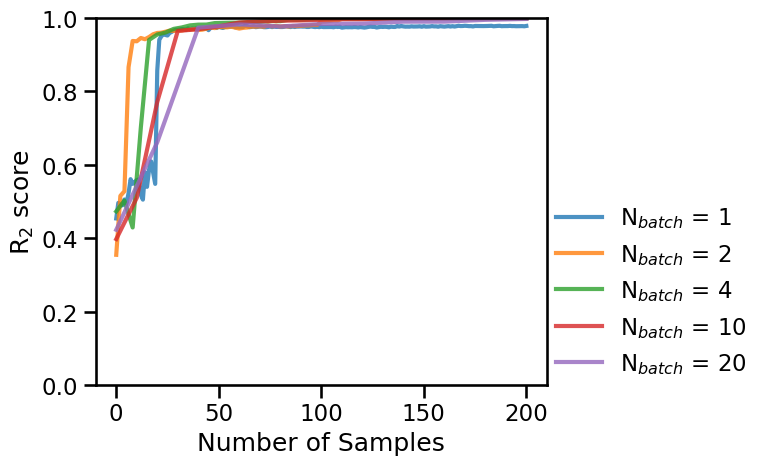

In [238]:
bor_bs = []
nbs = [1,2,4,10,20]
n_iter = 200

for nb in nbs:
    n_iter_b = int(n_iter/nb)
    borb = BO_RFR(X_init, y_init, grid, f, x_test, 
                 acq='BO',gl = get_label, cl_weight=1.5, 
                 est_labels=esl, N_batch=nb, 
                 class_method = 'RFC', reg_method = 'RFC', k_adaptive=False)
    
    borb.run(n_iter_b)
    bor_bs.append(borb)

fig, ax2 = plt.subplots(ncols=1, figsize=(8,5))
for nb,borb in zip(nbs,bor_bs):
    ax2.plot(np.arange(borb.n_iters+1)*nb,borb.scores,lw=3,alpha=0.8, label='N$_{batch}$ = %i'%nb)

#ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Samples')
ax2.set_ylabel('R$_2$ score')
ax2.set_ylim(0,1)
ax2.legend(loc=(1,0),frameon=False)
plt.tight_layout()

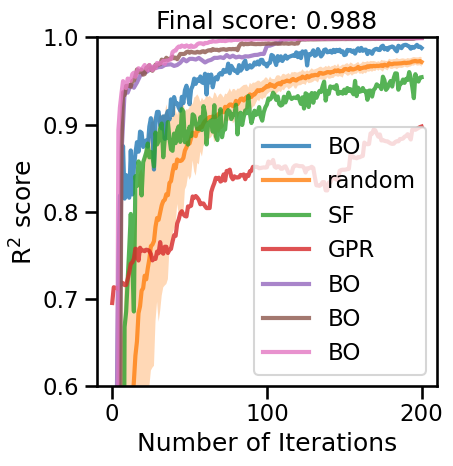

In [246]:
fig, ax2 = plt.subplots(ncols=1, figsize=(5,5))
nb=1
ax2.plot(np.arange(bor.n_iters+1)*nb,bor.scores,lw=3,alpha=0.8, label='this work')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0),lw=3,alpha=0.8, label='random')
    ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
                     np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),sf.scores,lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),gp.scores,lw=3,alpha=0.8, label='GPR')
except:
    pass


ax2.plot(np.arange(bor_bs[1].n_iters+1)*bor_bs[1].N_batch,bor_bs[1].scores,lw=3,alpha=0.8, label='BO')
ax2.plot(np.arange(bor2.n_iters+1)*nb,bor2.scores,lw=3,alpha=0.8, label='BO')
ax2.plot(np.arange(bor3.n_iters+1)*nb,bor3.scores,lw=3,alpha=0.8, label='BO')
ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$^2$ score')
ax2.set_ylim(0.6,1)
ax2.legend()
plt.tight_layout()

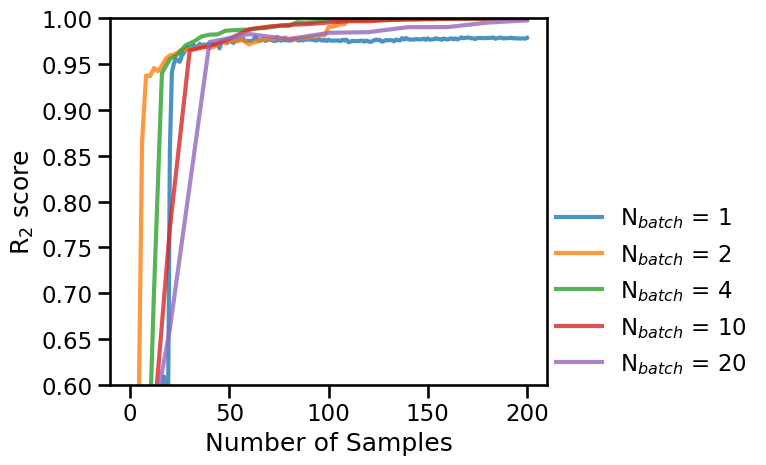

In [248]:
fig, ax2 = plt.subplots(ncols=1, figsize=(8,5))
for nb,borb in zip(nbs,bor_bs):
    ax2.plot(np.arange(borb.n_iters+1)*nb,borb.scores,lw=3,alpha=0.8, label='N$_{batch}$ = %i'%nb)

#ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Samples')
ax2.set_ylabel('R$_2$ score')
ax2.set_ylim(0.6,1)
ax2.legend(loc=(1,0),frameon=False)
plt.tight_layout()

plt.savefig('../../si_figures/pH_titration_batch.png', dpi=300)

TypeError: unsupported operand type(s) for -: 'list' and 'BO_RFR'

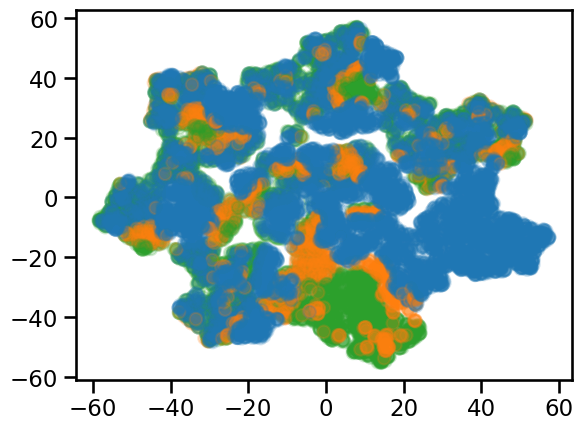

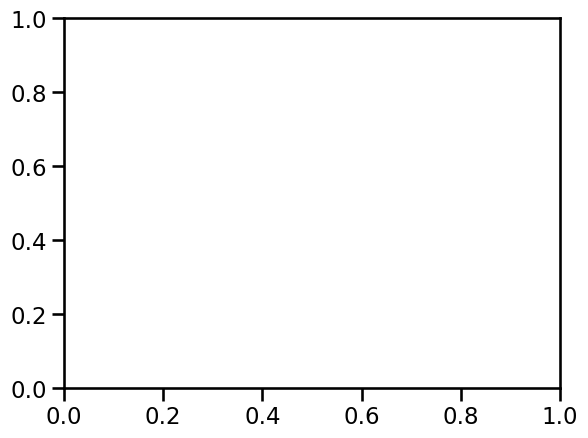

In [142]:
fig,ax = plt.subplots()
ax.scatter(*tsne.T, c=bor3.classifier.predict(grid),cmap='tab10', vmin=0,vmax=10,alpha=0.2)

fig,ax = plt.subplots()
diff = pHs-bor
ax.scatter(*tsne.T, c=diff,cmap='tab10', vmin=0,vmax=10,alpha=0.2)

fig,ax = plt.subplots()
diff = pHs-bor
ax.scatter(*tsne.T, c=diff,cmap='tab10', vmin=0,vmax=10,alpha=0.2)